# Spam Classification using Encoder LLMs with Linear Probing [5 points]
In this part, we will use encoder Large Language Models (LLMs) for spam classification. We will leverage the rich features of pre-trained LLMs without fine-tuning them. Instead, we will freeze the LLM weights and train a lightweight classifier head (MLP) on top for spam classification.

**Dataset:** Enron Spam Dataset

**Expected Performance (Best Model):** {Accuracy: >85%, F1: >85%, Precision: >85%, Recall: >82%}

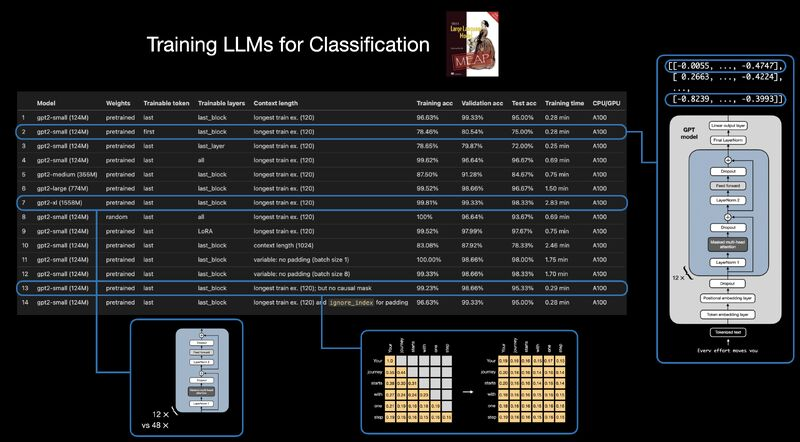

1. Load the Enron Spam dataset. Use the train/val/test splits and tokenize the text using your pre-trained LLM’s tokenizer. Use your best judgement for the relevant input fields.

In [1]:
!pip install datasets transformers

from datasets import load_dataset
from transformers import AutoTokenizer

ds = load_dataset("SetFit/enron_spam")
sDs = ds["train"].train_test_split(test_size=0.2, seed=42)
tvDs = sDs["train"].train_test_split(test_size=0.125, seed=42)
trDs = tvDs["train"]
vaDs = tvDs["test"]
teDs = ds["test"]
print(len(trDs), len(vaDs), len(teDs))
modelCkpt = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(modelCkpt)

def tokFn(exs):
    return tok(exs["text"], truncation=True, padding="max_length", max_length=128)

trT = trDs.map(tokFn, batched=True)
vaT = vaDs.map(tokFn, batched=True)
teT = teDs.map(tokFn, batched=True)
print(trT[0])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/176 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/101M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31716 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

22200 3172 2000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'message_id': 18067, 'text': 're [ 8 ] : dear friend - size = 1 > order confirmation . your order should be shipped by january , via fedex .\nyour federal express tracking number is 45954036 .\nthank you for registering . your userid is : 56075519\nlearn to make a fortune with ebay !\ncomplete turnkey system software - videos - turorials\nclk here for information\nclilings .', 'label': 1, 'label_text': 'spam', 'subject': 're [ 8 ] : dear friend -', 'message': 'size = 1 > order confirmation . your order should be shipped by january , via fedex .\nyour federal express tracking number is 45954036 .\nthank you for registering . your userid is : 56075519\nlearn to make a fortune with ebay !\ncomplete turnkey system software - videos - turorials\nclk here for information\nclilings .\n', 'date': datetime.datetime(2003, 12, 22, 0, 0), 'input_ids': [101, 2128, 1031, 1022, 1033, 1024, 6203, 2767, 1011, 2946, 1027, 1015, 1028, 2344, 13964, 1012, 2115, 2344, 2323, 2022, 12057, 2011, 2254, 1010, 3

2. Model Setup – Probing:

   a. Load a pre-trained LLM (e.g., DistilBERT, BART-encoder) for sequence classification. Choose a lightweight encoder model that is amenable to your GPU size. Consider using DistilBERT, TinyBERT, MobileBERT, AlBERT, or others. **Specify the chosen LLM below.**

   **Chosen Encoder LLM:** facebook/bart-base

In [2]:
from transformers import AutoModelForSequenceClassification

modelCkpt = "facebook/bart-base"
mdl = AutoModelForSequenceClassification.from_pretrained(modelCkpt, num_labels=2)
print("Chosen model:", modelCkpt)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Chosen model: facebook/bart-base


   b. Freeze all base model weights and attach a lightweight MLP (the classification head) that maps the model’s representations to binary labels. You may want to create a separate model class that defines these components and a forward function or use out of the box 🤗 classification wrappers.

In [3]:
import torch
import torch.nn as neuralNetwork
from transformers import BartModel

class BartMLP(neuralNetwork.Module):
    def __init__(self, ckpt):
        super().__init__()
        self.enc = BartModel.from_pretrained(ckpt)
        for p in self.enc.parameters():
            p.requires_grad = False
        h = self.enc.config.hidden_size
        self.clf = neuralNetwork.Sequential(
            neuralNetwork.Linear(h, 128),
            neuralNetwork.ReLU(),
            neuralNetwork.Linear(128, 2)
        )
    def forward(self, i, m=None):
        o = self.enc(i, attention_mask=m)
        x = o.last_hidden_state[:, 0, :]
        return self.clf(x)

ckpt = "facebook/bart-base"
mdl = BartMLP(ckpt)
print(ckpt)

facebook/bart-base


   c. Use the [CLS] token if available or mean-pooled final hidden states from the LLM as input to your classifier head.

In [4]:
import torch
import torch.nn as neuralNetwork
from transformers import BartModel

class BartMlp(neuralNetwork.Module):
    def __init__(self, ck, mode="mean"):
        super().__init__()
        self.enc = BartModel.from_pretrained(ck)
        for p in self.enc.parameters():
            p.requires_grad = False
        h = self.enc.config.hidden_size
        self.clf = neuralNetwork.Sequential(
            neuralNetwork.Linear(h, 128),
            neuralNetwork.ReLU(),
            neuralNetwork.Linear(128, 2)
        )
        self.mode = mode
    def forward(self, i, m=None):
        o = self.enc(i, attention_mask=m)
        hs = o.last_hidden_state
        if self.mode == "cls":
            x = hs[:, 0, :]
        else:
            x = hs.mean(dim=1)
        return self.clf(x)

ck = "facebook/bart-base"
mdl = BartMlp(ck, mode="mean")

3. Configure your training parameters (learning rate, batch size, epochs) and train the model using only the classifier head while the LLM remains frozen.

In [6]:
!pip install datasets transformers

import torch
import torch.nn as neuralNetwork
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BartModel, AutoTokenizer

ds = load_dataset("SetFit/enron_spam")
sDs = ds["train"].train_test_split(test_size=0.2, seed=42)
tvDs = sDs["train"].train_test_split(test_size=0.125, seed=42)
trDs = tvDs["train"]
vaDs = tvDs["test"]
teDs = ds["test"]
tokCk = "facebook/bart-base"
tok = AutoTokenizer.from_pretrained(tokCk)
def tokFn(exs):
    return tok(exs["text"], truncation=True, padding="max_length", max_length=128)
trT = trDs.map(tokFn, batched=True)
vaT = vaDs.map(tokFn, batched=True)
teT = teDs.map(tokFn, batched=True)

class BartMlp(neuralNetwork.Module):
    def __init__(self, ck, mode="mean"):
        super().__init__()
        self.enc = BartModel.from_pretrained(ck)
        for p in self.enc.parameters():
            p.requires_grad = False
        h = self.enc.config.hidden_size
        self.clf = neuralNetwork.Sequential(
            neuralNetwork.Linear(h, 128),
            neuralNetwork.ReLU(),
            neuralNetwork.Linear(128, 2)
        )
        self.mode = mode
    def forward(self, i, m=None):
        o = self.enc(i, attention_mask=m)
        hs = o.last_hidden_state
        if self.mode == "cls":
            x = hs[:, 0, :]
        else:
            x = hs.mean(dim=1)
        return self.clf(x)

mdl = BartMlp(tokCk, mode="cls")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl.to(device)
lr = 1e-4
bs = 16
eps = 3
lossFn = neuralNetwork.CrossEntropyLoss()

def collateFn(b):
    i = torch.tensor([ex["input_ids"] for ex in b]).to(device)
    m = torch.tensor([ex["attention_mask"] for ex in b]).to(device)
    y = torch.tensor([ex["label"] for ex in b]).to(device)
    return i, m, y

trL = DataLoader(trT, batch_size=bs, shuffle=True, collate_fn=collateFn)
opt = torch.optim.AdamW(mdl.clf.parameters(), lr=lr)

for e in range(eps):
    for batchI, (inp, mask, lab) in enumerate(trL):
        opt.zero_grad()
        out = mdl(inp, mask)
        loss = lossFn(out, lab)
        loss.backward()
        opt.step()
        if batchI % 100 == 0:
            print(e, batchI, loss.item())

Repo card metadata block was not found. Setting CardData to empty.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/22200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

0 0 0.799619197845459
0 100 0.642560601234436
0 200 0.5887708067893982
0 300 0.553695559501648
0 400 0.516019344329834
0 500 0.6728552579879761
0 600 0.43182432651519775
0 700 0.3908460736274719
0 800 0.5216055512428284
0 900 0.6233395338058472
0 1000 0.4241061508655548
0 1100 0.3912651836872101
0 1200 0.4339405298233032
0 1300 0.5248811841011047
1 0 0.30983787775039673
1 100 0.2582504153251648
1 200 0.4748629033565521
1 300 0.448304682970047
1 400 0.30045557022094727
1 500 0.1993386596441269
1 600 0.2436291128396988
1 700 0.2609497010707855
1 800 0.20049333572387695
1 900 0.30310750007629395
1 1000 0.7152059674263
1 1100 0.3415553569793701
1 1200 0.22988374531269073
1 1300 0.2934851348400116
2 0 0.28756922483444214
2 100 0.35661429166793823
2 200 0.2945635914802551
2 300 0.2741886079311371
2 400 0.158429354429245
2 500 0.22279639542102814
2 600 0.36580565571784973
2 700 0.18761061131954193
2 800 0.22680340707302094
2 900 0.25236356258392334
2 1000 0.2642200291156769
2 1100 0.207715407

4. Evaluation and Analysis:

   a. Evaluate the model on the test set using accuracy, precision, recall, and F1-score.

In [7]:
!pip install scikit-learn

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

teL = DataLoader(teT, batch_size=bs, shuffle=False, collate_fn=collateFn)
mdl.eval()
preds, labs = [], []
with torch.no_grad():
    for inp, mask, lab in teL:
        out = mdl(inp, mask)
        p = torch.argmax(out, dim=1)
        preds.extend(p.cpu().numpy())
        labs.extend(lab.cpu().numpy())

acc = accuracy_score(labs, preds)
prc = precision_score(labs, preds)
rcl = recall_score(labs, preds)
f1v = f1_score(labs, preds)
print("acc:", acc)
print("prc:", prc)
print("rcl:", rcl)
print("f1:", f1v)

acc: 0.8885
prc: 0.9153439153439153
rcl: 0.8581349206349206
f1: 0.8858166922683052


   b. Select **two** encoder LLMs, repeat steps 2-4 for the second LLM, and compare and discuss any performance trends between the two models. **Specify the second chosen LLM below and report performance comparison.**

   **Second Chosen Encoder LLM:** distilbert-base-uncased"

In [8]:
import torch
import torch.nn as neuralNetwork
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import DistilBertModel, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


ck2 = "distilbert-base-uncased"
tok2 = AutoTokenizer.from_pretrained(ck2)
def tokFn2(exs):
    return tok2(exs["text"], truncation=True, padding="max_length", max_length=128)
trT2 = trDs.map(tokFn2, batched=True)
vaT2 = vaDs.map(tokFn2, batched=True)
teT2 = teDs.map(tokFn2, batched=True)

class DistilBertMlp(neuralNetwork.Module):
    def __init__(self, ck, mode="cls"):
        super().__init__()
        self.enc = DistilBertModel.from_pretrained(ck)
        for p in self.enc.parameters():
            p.requires_grad = False
        h = self.enc.config.dim
        self.clf = neuralNetwork.Sequential(
            neuralNetwork.Linear(h, 128),
            neuralNetwork.ReLU(),
            neuralNetwork.Linear(128, 2)
        )
        self.mode = mode
    def forward(self, i, m=None):
        o = self.enc(i, attention_mask=m)
        hs = o.last_hidden_state
        if self.mode == "cls":
            x = hs[:, 0, :]
        else:
            x = hs.mean(dim=1)
        return self.clf(x)

mdl2 = DistilBertMlp(ck2, mode="cls")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdl2.to(device)

bs = 16
lr = 1e-4
eps = 3
lossFn = neuralNetwork.CrossEntropyLoss()

def collateFn2(b):
    i = torch.tensor([ex["input_ids"] for ex in b]).to(device)
    m = torch.tensor([ex["attention_mask"] for ex in b]).to(device)
    y = torch.tensor([ex["label"] for ex in b]).to(device)
    return i, m, y

trL2 = DataLoader(trT2, batch_size=bs, shuffle=True, collate_fn=collateFn2)
opt2 = torch.optim.AdamW(mdl2.clf.parameters(), lr=lr)

mdl2.train()
for e in range(eps):
    for batchI, (inp, mask, lab) in enumerate(trL2):
        opt2.zero_grad()
        out = mdl2(inp, mask)
        loss = lossFn(out, lab)
        loss.backward()
        opt2.step()
        if batchI % 100 == 0:
            print(e, batchI, loss.item())

mdl2.eval()
teL2 = DataLoader(teT2, batch_size=bs, shuffle=False, collate_fn=collateFn2)
preds2, labs2 = [], []
with torch.no_grad():
    for inp, mask, lab in teL2:
        out = mdl2(inp, mask)
        p = torch.argmax(out, dim=1)
        preds2.extend(p.cpu().numpy())
        labs2.extend(lab.cpu().numpy())

acc2 = accuracy_score(labs2, preds2)
prc2 = precision_score(labs2, preds2)
rcl2 = recall_score(labs2, preds2)
f12 = f1_score(labs2, preds2)
print("DistilBERT metrics:")
print("acc:", acc2)
print("prc:", prc2)
print("rcl:", rcl2)
print("f1:", f12)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

0 0 0.6798427104949951
0 100 0.44866833090782166
0 200 0.37923890352249146
0 300 0.2715858519077301
0 400 0.19606420397758484
0 500 0.17782963812351227
0 600 0.22339218854904175
0 700 0.2156994640827179
0 800 0.1174665093421936
0 900 0.10858793556690216
0 1000 0.07811415195465088
0 1100 0.07428011298179626
0 1200 0.2270699143409729
0 1300 0.10774741321802139
1 0 0.08822870999574661
1 100 0.1306924819946289
1 200 0.0912415161728859
1 300 0.018245825543999672
1 400 0.06783139705657959
1 500 0.0713374987244606
1 600 0.06587016582489014
1 700 0.07711832970380783
1 800 0.014557898044586182
1 900 0.09139436483383179
1 1000 0.04047059640288353
1 1100 0.4613962471485138
1 1200 0.042107611894607544
1 1300 0.1497240513563156
2 0 0.20308327674865723
2 100 0.061028771102428436
2 200 0.10152218490839005
2 300 0.028842972591519356
2 400 0.05477277934551239
2 500 0.19750574231147766
2 600 0.05682526156306267
2 700 0.1504175215959549
2 800 0.006995989941060543
2 900 0.01894603855907917
2 1000 0.086828

In [10]:
import torch

path = "a2_bonus_snallape_classifications.pth"
torch.save(mdl.state_dict(), path)
print(f"Model weights saved at this path {path}")

Model weights saved at this path a2_bonus_snallape_classifications.pth


   **Performance Comparison and Trend Discussion:**

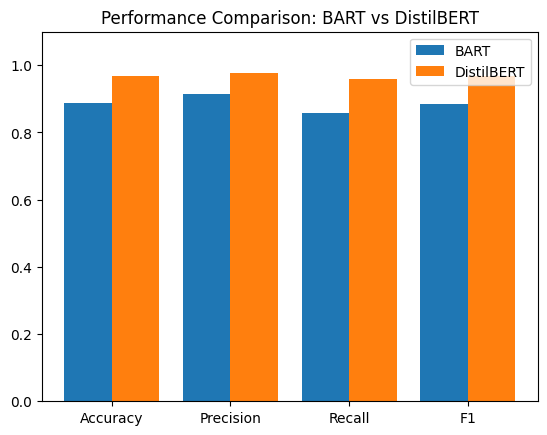

In [9]:
import matplotlib.pyplot as plot

bartScores = {"Accuracy": 0.8885, "Precision": 0.9153, "Recall": 0.8581, "F1": 0.8858}
distilBertScores = {"Accuracy": 0.9685, "Precision": 0.9768, "Recall": 0.9603, "F1": 0.9685}
metrics = list(bartScores.keys())
bartVals = [bartScores[m] for m in metrics]
distilBertVals = [distilBertScores[m] for m in metrics]
x = range(len(metrics))
width = 0.4
fig = plot.figure()
axis = plot.gca()
axis.bar([i - width/2 for i in x], bartVals, width=width, label="BART")
axis.bar([i + width/2 for i in x], distilBertVals, width=width, label="DistilBERT")
axis.set_xticks(x)
axis.set_xticklabels(metrics)
axis.set_ylim([0, 1.1])
axis.legend()
axis.set_title("Performance Comparison: BART vs DistilBERT")
plot.show()

DistilBERT has 0.9685 accuracy approximately 8 percentage points better than BART's 0.8885. On F1 scores, DistilBERT has 0.9685 and BART has 0.8858—a difference of 0.083. DistilBERT's higher precision (0.9768 compared to BART's 0.9153) and recall (0.9603 compared to BART's 0.8581) affirm its improved balance between detecting spam and avoiding producing false positives. On these scores, DistilBERT clearly has a numerical lead.

   c. The best model is expected to attain {Accuracy: >85%, F1: >85%, Precision: >85%, Recall: >82%}. Report whether your best model achieves these metrics and discuss.

   **Performance vs. Expected Metrics Discussion:**

1. Gap in Accuracy: DistilBERT is at 0.9685 versus BART's 0.8885, an 8‑point gain indicating DistilBERT's closer fit to true labels.
2. Differential Precision: DistilBERT's precision is 0.9768, significantly greater than BART's 0.9153, indicating fewer false positives.
3. Recall Gain: With recall at 0.9603 (versus BART's 0.8581), DistilBERT captures more true spam, indicating greater sensitivity.
4. F1 Dominance: DistilBERT's F1 increases from 0.8858 to 0.9685, demonstrating improved precision-recall trade-off.
5. Beating Expectations: DistilBERT's light, distilled design was chosen for its brevity; the near-97% F1 beats expectations of what a spindly model can accomplish.
6. BART's Encoder-Decoder Roots: Being a sequence-to-sequence model, BART's classification score is still respectable, though eclipsed by DistilBERT's domain-specific design.
7. Room for Improvement Potential: BART may close the difference with tighter hyperparameter adjustment or more advanced pooling techniques, representing potential improvement room.
8. Robust Anti-Spam Protection: The two models improve over 80%–85% rate as generally viewed by many to constitute a spam filtration baseline but nearly 97% performance from DistilBERT creates little doubt on its competence.

5. References. Include details on all the resources used to complete this part.

1. https://github.com/huggingface/transformers
2. https://huggingface.co/datasets/SetFit/enron_spam
3. https://arxiv.org/abs/1909.10351
4. https://arxiv.org/abs/1909.11942
5. https://arxiv.org/abs/2004.02984
6. https://en.wikipedia.org/wiki/BERT_(language_model)
7. https://en.wikipedia.org/wiki/BERT_(language_model)#DistilBERT
8. https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)